In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set_style('whitegrid')

# Exercise 1: Permutation Feature Importance Exercise

### a) 

Permutation Feature Importance compares the performance of the model on the original data with the performance on perturbed data, where the dependence of the variable of interest (let's call it $x_j$) with the target $Y$ variable is broken.

In order to break the dependence of $x_j$ with $y$, $x_j$ is replaced with a permuted version $\tilde{x}_j$ which is independent of the target.

However, by permuting the variable we do not only break the dependence with $y$, but also with all other covariates. As such, we may create unrealistic observations.

For example, time of the year may be dependent with the highest temperature on a day. If we resample the variable time of the year independently of the temperature high, we may create observations where time of the year is winter and temperature high is 40 degrees celsius.

### b)

If a feature anyway independent of its covarites ($x_j \perp x_{-j}$, then PFI does not extrapolate to unseen regions.

Intuitively, the reason is that no dependence with the covariates is broken, since there were not dependencies between $x_j$ and the remaining variables $x_{-j}$ to begin with..

We discuss the theoretical background of the issue in more detail in the in-class exercise.

### c)

In [ ]:
df = pd.read_csv('extrapolation.csv', index_col=0)

X, y = df[df.columns[df.columns != 'y']], df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

model = LinearRegression()
model.fit(X_train, y_train)

print('MSE: {}'.format(mean_squared_error(model.predict(X_test), y_test)))

MSE: 0.008937939178929953


## d)



First, we implement PFI. Here we implement the methods generically, such that the perturbation mechanism can easily be replaced. Therefore, we make use of *args and **kwargs.

In [ ]:
def pfi_fname(fname, predict, score, X_test, y_test, *args):
    """Function that returns the pfi for a single feature.

    Args:
        fname: feature of interest name
        predict: prediciton function
        score: performance metric
        X_test: data for the evaluation
        y_test: respective labels
        *args: further arguments (which are ignored)

    Returns:
        performance: performance metric
    """
    X_test_perturbed = X_test.copy(deep=True)
    X_test_perturbed[fname] = np.random.permutation(X_test_perturbed[fname])
    performance = score(y_test, predict(X_test_perturbed)) - score(y_test, predict(X_test))
    return performance

def fi_naive(fi_fname, predict, score, X_test, y_test, *args, **kwargs):
    """Naive feature importance implementation.

    Args:
        perf_pert: function that returns performance for some perturbation.
        predict: prediction function
        score: performance metric
        X_test: test data for the evaluation
        y_test: respective labels
        *args: further arguments, e.g. training data (can be ignored here)

    Returns:
        results: relevance for each feature (in the order of X_test.columns)
    """
    # compute performance under perturbation
    results = []
    for fname in X_test.columns:
        imp = fi_fname(fname, predict, score, X_test, y_test, *args, **kwargs)
        results.append(imp)
    # compute pfi scores
    results = np.array(results)
    return results

import multiprocess as mp

def n_times(n, method, *args, return_raw=False, **kwargs):
    """Parallelized implementation for the repeated evaluation of fi.

    Args:
        n: number of repetitions
        method: feature importance method.
        args: all further arguments that are required for the method
        return_raw: Whether only the aggregation (mean, stdd) or also the raw results are returned
    
    Returns:
        mean_fi, std_fi, (raw results)
    """
    pool = mp.Pool(mp.cpu_count())
    with pool: # a simple for loop would be ok as well
        results = [pool.apply(method, args=args, kwds=kwargs) for _ in range(n)]
    results = np.array(results)
    if return_raw:
        return np.mean(results, axis=0), np.std(results, axis=0), results
    else:
        return np.mean(results, axis=0), np.std(results, axis=0)

Now we apply the method to our model and dataset.

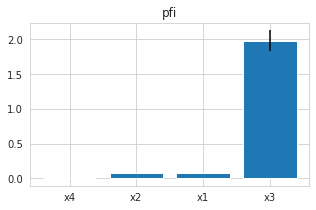

In [ ]:
nr_runs = 10

plt.figure(figsize=(5, 3))
plt.title('pfi')
fis_mean, fis_std = n_times(nr_runs, fi_naive, pfi_fname, model.predict, mean_squared_error, X_test, y_test, return_raw=False)
ordering = np.argsort(fis_mean)
plt.bar(X_test.columns[ordering], fis_mean[ordering], yerr=fis_std[ordering])
plt.show()

### e)

$X_3$ is the most important feature, with $X_1$ and $X_2$ sharing the second place. PFI considers $X_4$ to be irrelevant.

According to the PFI interpretation rules, without further assumptions about the data, we know that

- $X_1, X_2, X_3$ are used by the model for it's prediction
- $X_1, X_2, X_3$ are dependent with $Y$ and/or dependent with the covariates
- $X_4$ may be independent of $Y$ and covariates and/or not used by the model. We only know that it is not both dependent and used by the model.

Bonus: If we would additionally analyze the data we find out that $X_1, X_2$ are dependent but $X_3$ is independent of all covariates.

As such, we could further conclude that $X_3$ is dependent with $Y$ (but do not know for $X_1, X_2$ without looking into the data).

### f)

In [ ]:
print(model.coef_, model.intercept_)

[-0.20295108  0.20318676  1.00971948  0.00611803] 0.0025435035702275517


In [ ]:
from scipy.stats import pearsonr
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,x1,x2,x3,x4,y
x1,1.0***,1.0***,0.03,-0.05,0.02
x2,1.0***,1.0***,0.03,-0.05,0.02
x3,0.03,0.03,1.0***,-0.0,1.0***
x4,-0.05,-0.05,-0.0,1.0***,0.0
y,0.02,0.02,1.0***,0.0,1.0***


Our interpretation was correct.

### g)

If we know the dependence structure of the covariates we can infer whether or not the PFI value is nonzero due to a dependence with the covariates or not. In our example we now know that $x_3$ is independent of its covariates, so we hypothesize that $x_3$ is actually dependent with $y$ (and would perform importance tests as a consequence). Since $x_1, x_2$ are dependent, for those variables we cannot infer anything about the dependence with $y$ with the covariates dependence structure and PFI alone.

## h)

We use the $\texttt{extrapolation.csv}$ dataset. We create a pairplot showing the pairwise scatterplot of the original feature as well as the corresponding perturbed variable with all remaining feature variables (and potentially $y$).

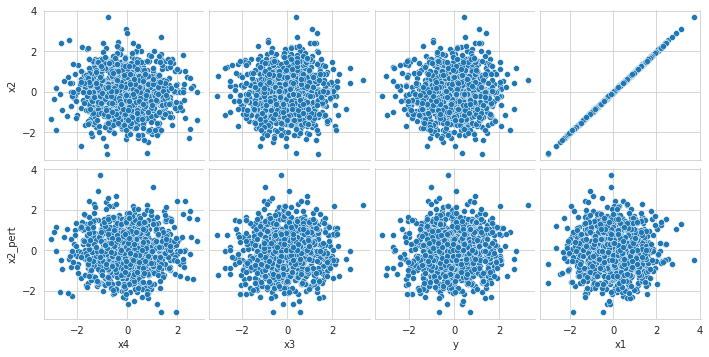

In [ ]:
def pairplot_comparison(data, fname):
    data.loc[:, fname+'_pert'] = np.random.permutation(data.loc[:, fname])
    data = data[sorted(data.columns)]
    all_except_fname = list(set(data.columns) - set([fname, fname + '_pert']))
    sns.pairplot(data, y_vars=[fname, fname+'_pert'], x_vars=all_except_fname)

pairplot_comparison(df, 'x2')

We can see that the strong correlation of $x_2$ with $x_1$ (top row) is broken after permutation (bottom row). All other pairwise (in)dependencies are unchanged. Note: We only assess pairwise, unconditional dependencies. Without assumptions about the data, we cannot know whether further conditional depencies with the remaining covariates were broken.

# Exercise 2: Feature Importance without Extrapolation

### a)

An efficient, $\texttt{pytorch}$ based implementation is given in a separate file ($\texttt{utils.py}$).

In order to keep things clean, we only provide a small wrapper function here.

In [ ]:
import utils

def sample_cond(J, C, X_train, X_test, num_samples=1):
    """Conditional sampler"""
    dist = utils.GaussianConditionalEstimator()
    dist.fit(X_train[sorted(J)].to_numpy(), X_train[sorted(C)].to_numpy())
    sample = dist.sample(X_test[sorted(C)].to_numpy(), num_samples=num_samples)
    iterables = [list(X_test.index), list(range(sample.shape[1]))]
    index = pd.MultiIndex.from_product(iterables, names=["i", "sample"])
    sample_df = pd.DataFrame(sample.reshape(-1, len(J)), columns=sorted(J), index=index)
    return sample_df
    

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
J = ['x1', 'x3']
C = ['x2', 'x4']
sample = sample_cond(J, C, X_train, X_test, num_samples=10)
sample.head()

x1        x3
i   sample                    
653 0       0.545276  0.081977
    1       0.511839 -0.691888
    2       0.521899 -1.500667
    3       0.522237 -0.686662
    4       0.503619 -0.536446

## b) 

We implement conditional feature importance (CFI).

In [ ]:
def cfi_fname(fname, predict, score, X_test, y_test, X_train, *args):
    """conditional feature importance for a feature fname"""
    X_test_perturbed = X_test.copy(deep=True)
    C = sorted(X_test.columns[X_test.columns != fname])
    sample = sample_cond([fname], C, X_train, X_test)
    X_test_perturbed[fname] = sample.to_numpy()
    performance = score(y_test, predict(X_test_perturbed))  - score(y_test, predict(X_test))
    return performance

## c) 

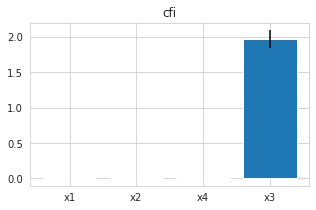

In [ ]:
nr_runs = 10

plt.figure(figsize=(5, 3))
plt.title('cfi')
fis_mean, fis_std = n_times(nr_runs, fi_naive, cfi_fname, model.predict, mean_squared_error, X_test, y_test, X_train, return_raw=False)
ordering = np.argsort(fis_mean)
plt.bar(X_test.columns[ordering], fis_mean[ordering], yerr=fis_std[ordering])
plt.show()

Now, only $X_3$ is considered relevant. We konw that

- $X_3$ is conditionally dependent with $Y$ ($X_3 \not \perp Y | X_1, X_2, X_4$) and it is used by the model
- without further assumtions, we cannot make conclusions about the remaining variables. We only know that they are not at the same time conditionally dependent with $Y$ and used by the model for it's prediction.

### d)

In [ ]:
import pandas as pd

idx = pd.IndexSlice

def repeat_df(df, n):
    """function that repeats dataframe with multiindex"""
    ix_1 = df.index
    multindex = pd.MultiIndex.from_product([list(ix_1), list(range(n))], names=['i', 'sample'])
    df_new = pd.DataFrame([], columns=df.columns, index=multindex)
    for ii in range(n):
        df_new.loc[idx[:, ii], df.columns] = df[df.columns].to_numpy()
    return df_new

def c_value_func_partial(J, predict, score, X_test, y_test, X_train, n_marginalize=10):
    """partial value function, i.e. performance given all features are
    reconstructed conditional on the set J, marginalization of the prediction
    over the remaining features
    """
    C = [f for f in X_test.columns if f not in J]
    if len(C) == 0:
        return score(predict(X_test), y_test)
    sample = sample_cond(C, J, X_train, X_test, num_samples=n_marginalize)
    X_test_pert = repeat_df(X_test, n_marginalize)
    X_test_pert[C] = sample.loc[X_test_pert.index, C].to_numpy()
    X_test_pert['y_hat'] = predict(X_test_pert)
    y_hat_agg = X_test_pert['y_hat'].groupby('i', sort=False).mean().loc[X_test.index]
    return score(y_hat_agg, y_test)

def c_value_func(J, S, *args, **kwargs):
    """conditional sage value function of variables j given coalition S"""
    return c_value_func_partial(S, *args, **kwargs) - c_value_func_partial(J + S, *args, **kwargs)

def sage_val_empty(fname, predict, score, X_test, y_test, X_train, n_marginalize=10):
    """sage value given empty coalition"""
    return c_value_func([fname], [], predict, score, X_test, y_test, X_train, n_marginalize=n_marginalize)

def sage_val_remainder(fname, predict, score, X_test, y_test, X_train, n_marginalize=10):
    """sage value given full remainder as coaliation"""
    remainder = [f for f in X_test.columns if f != fname]
    return c_value_func([fname], remainder, predict, score, X_test, y_test, X_train, n_marginalize=n_marginalize)


### e)

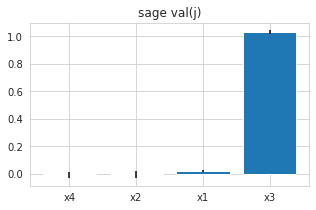

In [ ]:
nr_runs = 10
n_marginalize=50

plt.figure(figsize=(5, 3))
plt.title('sage val(j)')
fis_mean, fis_std = n_times(nr_runs, fi_naive, sage_val_empty, model.predict, mean_squared_error, X_test, y_test, X_train, n_marginalize=n_marginalize)
ordering = np.argsort(fis_mean)
plt.bar(X_test.columns[ordering], fis_mean[ordering], yerr=fis_std[ordering])
plt.show()

We can hypothesize that $x_3$ is pairwise dependent with $y$, while all other variables are pairwise independent with $y$. We learn that $x_3$ is used by the model. We do not know for the remaining variables.

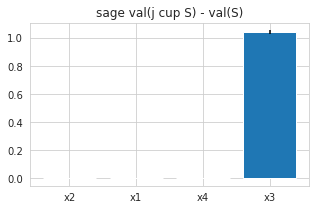

In [ ]:
nr_runs = 10
n_marginalize = 50

plt.figure(figsize=(5, 3))
plt.title('sage val(j cup S) - val(S)')
fis_mean, fis_std = n_times(nr_runs, fi_naive, sage_val_remainder, model.predict, mean_squared_error, X_test, y_test, X_train, n_marginalize=n_marginalize)
ordering = np.argsort(fis_mean)
plt.bar(X_test.columns[ordering], fis_mean[ordering], yerr=fis_std[ordering])
plt.show()

We additionally learn that the contribution of $x_3$ is unaffected by knowing further covariables.

## Exercise 3: Refitting based importance

### a)

In [ ]:
from sklearn.base import clone

def loco(fname, predict, score, X_test, y_test, X_train, y_train, model):
    """loco importance for feature fname"""
    y_hat_pre = predict(X_test)
    model_new = clone(model)
    remainder = [f for f in X_train.columns if f != fname]
    model_new.fit(X_train[remainder], y_train)
    y_hat_post = model_new.predict(X_test[remainder])
    diff = score(y_hat_post, y_test) - score(y_hat_pre, y_test)
    return diff

### b)

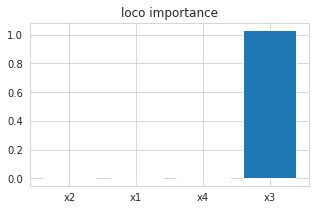

In [ ]:
nr_runs = 10

plt.figure(figsize=(5, 3))
plt.title('loco importance')
fis_mean, fis_std = n_times(nr_runs, fi_naive, loco, model.predict, mean_squared_error, X_test, y_test, X_train, y_train, model)
ordering = np.argsort(fis_mean)
plt.bar(X_test.columns[ordering], fis_mean[ordering], yerr=fis_std[ordering])
plt.show()

### c)

Result is similar as for SAGE and CFI: only feature $x_3$ is considered relevant. We learn that $x_3$ provides more information than the remaining features combined, (while the other features do not contribute to the performance at all).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=249d1b8e-109f-4b94-b0ef-ed5d22171b28' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>